# Post-process for 2D Channel Flow on Coarse Mesh

**Table of Content**

0. Function Definitions
1. Check on Mesh and Velocity
2. Test on matrix inverse on each section
3. Test on Local Condition Number on Each Section

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 400
%matplotlib inline
pd.options.display.max_rows = 20
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import inv as spInv
import os

In [2]:
import scipy.sparse.linalg as splg
import scipy.linalg as slg
from scipy.linalg import norm as snorm

In [3]:
# splg.norm?
# snorm?

## 0. Function Definitions

In [4]:
def get_TimeGeneral(case_dir):
    file_name = case_dir+'/latestTime'
    time = np.loadtxt(file_name, dtype=int).item()
    return time

def get_FoamData_scalar(feat_str, data_dir, N=20193, skr=23):  
    filename = data_dir + feat_str
    dataframe = pd.read_table(filename, skiprows=skr, nrows=N, header=None, sep='\s+')
    dataframe = dataframe.apply(pd.to_numeric, errors='ignore')
    return dataframe

def get_FoamData_vector(feat_str, data_dir, N=20193, skr=23):
    filename = data_dir + feat_str
    dataframe = pd.read_table(filename, skiprows=skr, nrows=N, header=None, sep='\s+')
    dataframe[0] = dataframe[0].str.split('(', expand=True)[1]
    dataframe[2] = dataframe[2].str.split(')', expand=True)[0]
    dataframe = dataframe.apply(pd.to_numeric, errors='ignore')
    return dataframe

def get_FoamData_symmTensor(feat_str, data_dir, N=20193, skr=23):  
    filename = data_dir + feat_str
    dataframe = pd.read_table(filename, skiprows=skr, nrows=N, header=None, sep='\s+')
    dataframe[0] = dataframe[0].str.split('(', expand=True)[1]
    dataframe[5] = dataframe[5].str.split(')', expand=True)[0]
    dataframe = dataframe.apply(pd.to_numeric, errors='ignore')
    return dataframe

In [5]:
def get_SparseMatrix(fileName):
    A_sparse = np.loadtxt(fileName)
    row = np.array(A_sparse[:,0], dtype=int)
    col = np.array(A_sparse[:,1], dtype=int)
    data = A_sparse[:,2]
    A_spm = coo_matrix((data, (row, col)))
    return A_spm

def ErrorSumAbs(a, b):
    err = np.sum(np.abs(a-b))
    return err

In [6]:
def get_NonZerosIndex(data1D):
    arr = np.array(data1D).ravel()
    N = arr.shape[0]
    ind = np.array([], dtype=int)
    for i in range(N):
        if (arr[i]!=0):
            ind = np.append(ind, i)
    return ind

def get_NonZerosIndex2D(data2D):
    nx, ny = data2D.shape
    row = np.array([], dtype=int)
    col = np.array([], dtype=int)
    for i in range(nx):
        temp = np.array(data2D[i]).reshape(ny)
        ind1 = get_NonZerosIndex(temp)
        size = ind1.shape[0]
        if (size>0):
            rowtemp = i*np.ones(size, dtype=int)
            row = np.append(row, rowtemp)
            col = np.append(col, ind1)
    return row, col

def findLocationFromIndex(nid, index):
    nx, ny = index.shape
    loci = -1
    locj = -1
    for i in range(nx):
        for j in range(ny):
            if (index[i,j] == nid):
                loci = i
                locj = j
    return loci, locj

## 1. Check on Mesh and Velocity

In [7]:
dir_case = './2D/R0180-coarse/'
runTime = str(get_TimeGeneral('./2D/R0180-coarse/'))
index = np.loadtxt(dir_case+'/indexStructured', dtype=int)
nx, ny = index.shape
nCells = nx*ny

In [8]:
U_RANS = get_FoamData_vector('U',dir_case+'/'+runTime+'/', nCells).values
U_DNS = get_FoamData_vector('U_DNS',dir_case+'/'+runTime+'/', nCells).values
Grid = get_FoamData_vector('PointsC',dir_case+'/'+runTime+'/', nCells).values
gridX = np.zeros((nx, ny))
gridY = np.zeros((nx, ny))
for i in range(nx):
    for j in range(ny):
        gridX[i,j] = Grid[index[i,j], 0]
        gridY[i,j] = Grid[index[i,j], 1]

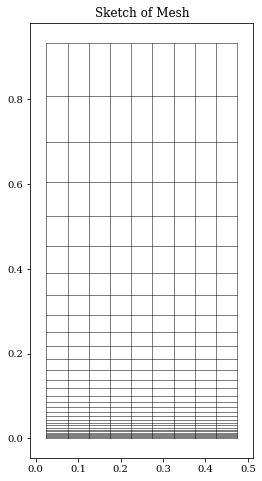

In [9]:
plt.figure(figsize=(4,8))
plt.axis('equal')
plt.title('Sketch of Mesh')
for i in range(nx):
    plt.plot(gridX[i,:], gridY[i,:],'k',linewidth=0.5)
for j in range(ny):
    plt.plot(gridX[:,j], gridY[:,j],'k',linewidth=0.5)
# plt.savefig('./figures/Mesh')
plt.show()

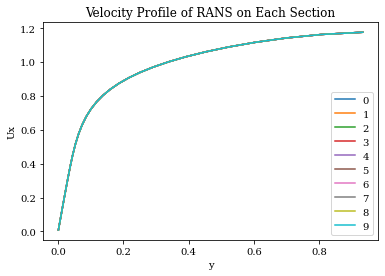

In [10]:
plt.figure()
plt.title('Velocity Profile of RANS on Each Section')
Ux_RANS_sec = np.zeros(ny)
for i in range(nx):
    for j in range(ny):
        Ux_RANS_sec[j] = U_RANS[index[i,j], 0]
    plt.plot(gridY[i], Ux_RANS_sec, label=str(i))
plt.legend()
plt.xlabel('y')
plt.ylabel('Ux')
# plt.savefig('./figures/Ux_RANS_AllSec')
plt.show()

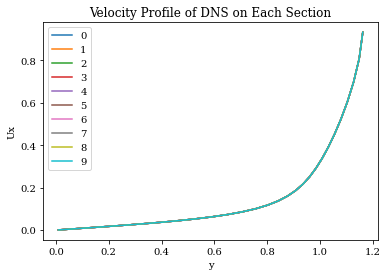

In [11]:
plt.figure()
plt.title('Velocity Profile of DNS on Each Section')
Ux_DNS_sec = np.zeros(ny)
for i in range(nx):
    for j in range(ny):
        Ux_DNS_sec[j] = U_DNS[index[i,j], 0]
    plt.plot(Ux_DNS_sec, gridY[i], label=str(i))
plt.legend()
plt.xlabel('y')
plt.ylabel('Ux')
# plt.savefig('./figures/Ux_DNS_AllSec')
plt.show()

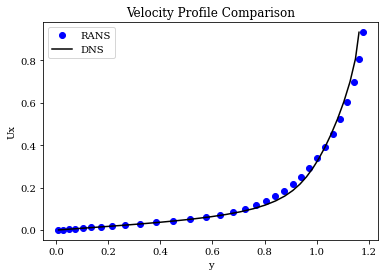

In [12]:
plt.figure()
plt.title('Velocity Profile Comparison')
plt.plot(Ux_RANS_sec, gridY[i], 'bo', label='RANS')
plt.plot(Ux_DNS_sec, gridY[i], 'k' , label='DNS')
plt.legend()
plt.xlabel('y')
plt.ylabel('Ux')
# plt.savefig('./figures/Ux_Comparison')
plt.show()

## 2. Test on matrix inverse on each section

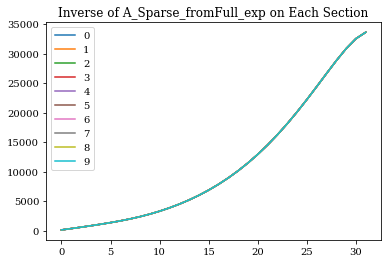

In [13]:
rj2 = get_FoamData_scalar('rj_exp',dir_case+'/'+runTime+'/', nCells).values
plt.figure()
plt.title('Inverse of A_Sparse_fromFull_exp on Each Section')
rj_section = np.zeros(ny)
for i in range(nx):
    for j in range(ny):
        rj_section[j] = rj2[index[i,j]]
    plt.plot(rj_section, label=str(i))
plt.legend()
# plt.savefig('./figures/rj_exp_AllSec')
plt.show()

## 3. Test on Local Condition Number on Each Section

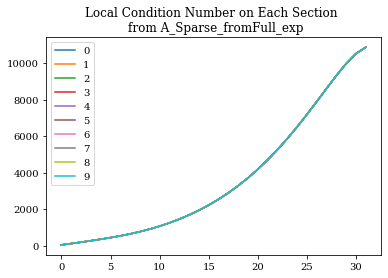

In [14]:
Kj1 = get_FoamData_scalar('Kj_exp',dir_case+'/'+runTime+'/', nCells).values
plt.figure()
plt.title('Local Condition Number on Each Section \n from A_Sparse_fromFull_exp')
Kj_section = np.zeros(ny)
for i in range(nx):
    for j in range(ny):
        Kj_section[j] = Kj1[index[i,j]]
    plt.plot(Kj_section, label=str(i))
plt.legend()
# plt.savefig('./figures/Kj_DD_AllSec')
plt.show()